# 08 Demo: SNOTEL Query and Download

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## SNOTEL Introduction
Read a bit about SNOTEL data for the Western U.S.:
* https://www.nrcs.usda.gov/wps/portal/wcc/home/aboutUs/snowProgramOverview
* https://www.nrcs.usda.gov/wps/portal/wcc/home/#elements=&networks=SNTL,SNTLT

This is actually a nice web interface, with some advanced querying and interactive visualization.  You can also download formatted ASCII files (csv) for analysis.  This is great for one-time projects, but it's nice to have reproducible code that can be updated as new data appear, without manual steps.  That's what we're going to do here.

### About SNOTEL sites and data:
* https://www.nrcs.usda.gov/wps/portal/wcc/home/aboutUs/monitoringPrograms/automatedSnowMonitoring
* https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=27630.wba
    * Check out the measurement information for Snow Depth sensor in Table 2-4 

### Sample plots for SNOTEL site at Paradise, WA (south side of Mt. Rainier)
* https://www.nwrfc.noaa.gov/snow/snowplot.cgi?AFSW1
* We will reproduce some of these plots/metrics during this lab

### Interactive dashboard
* https://climate.washington.edu/climate-data/snowdepth/

### Snow today
* https://nsidc.org/reports/snow-today

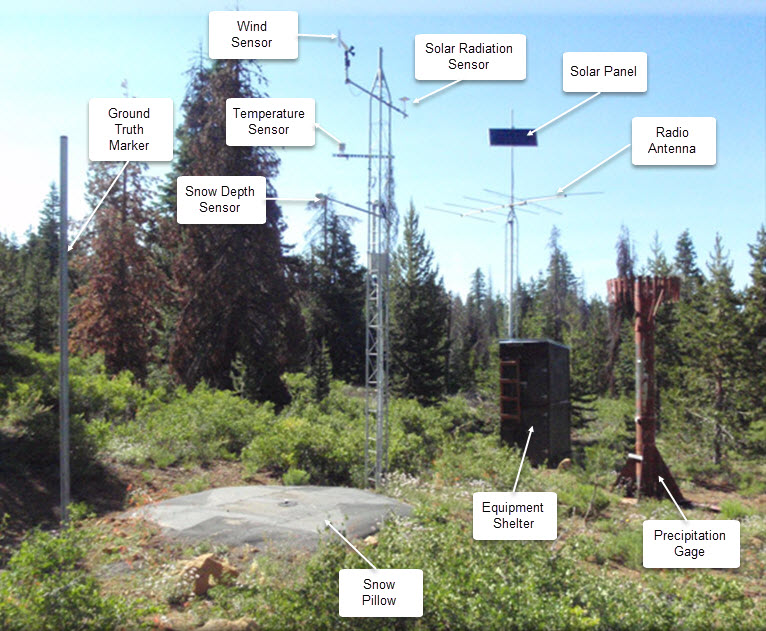

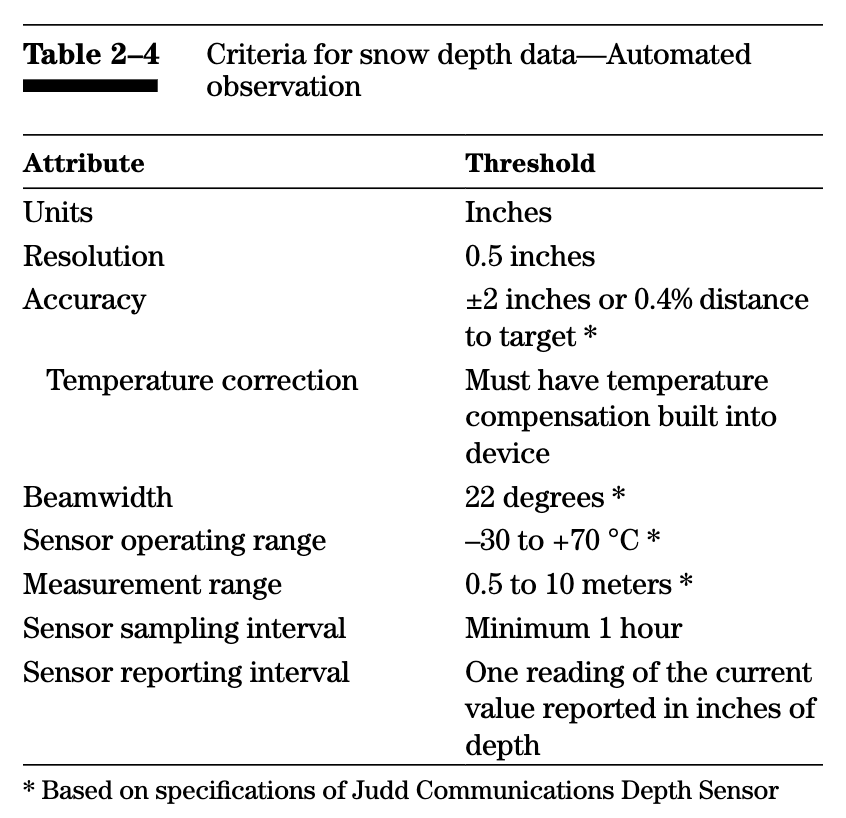

## CUAHSI WOF server and automated Python data queries
We are going to use a server set up by CUAHSI to serve the SNOTEL data, using a standardized database storage format and query structure.  You don't need to worry about this, but please quickly review the following:
* http://hiscentral.cuahsi.org/pub_network.aspx?n=241 
* http://his.cuahsi.org/wofws.html

### Acronym soup
* SNOTEL = Snow Telemetry
* CUAHSI = Consortium of Universities for the Advancement of Hydrologic Science, Inc
* WOF = WaterOneFlow
* WSDL = Web Services Description Language
* USDA = United States Department of Agriculture
* NRCS = National Resources Conservation Service
* AWDB = Air-Water Database

### Python options
There are a few packages out there that offer convenience functions to query the online SNOTEL databases and unpack the results.  
* climata (https://pypi.org/project/climata/) - last commit Sept 2017 (not a good sign)
* ulmo (https://github.com/ulmo-dev/ulmo) - last commit Sept 2021 (will be superseded by a package called Quest, but still maintained by [Emilio Mayorga](https://apl.uw.edu/people/profile.php?last_name=Mayorga&first_name=Emilio) over at UW APL)

You can also write your own queries using the Python `requests` module and some built-in XML parsing libraries.

Hopefully not overwhelming amount of information - let's just go with ulmo for now.  I've done most of the work to prepare functions for querying and processing the data.  Once you wrap your head around all of the acronyms, it's pretty simple, basically running a few functions here: https://ulmo.readthedocs.io/en/latest/api.html#module-ulmo.cuahsi.wof

We will use ulmo with daily data for this exercise, but please feel free to experiment with hourly data, other variables or other approaches to fetch SNOTEL data.

### ulmo installation
* Note that `ulmo` is not part of the default Hub environment
* We will cover more on conda and environment management in coming weeks, but know that you can temporarily install packages from terminal or even in Jupyterhub notebook
    * When running conda install from notebook, make sure to use the `-y` flag to avoid interactive prompt
* Note that packages installed this way won't persist when your server is shut down, so you will need to reinstall to use again
    * Fortunately, once we've used ulmo for data access and download, we won't need it again

In [ ]:
#Doesn't work until ulmo is installed
#import ulmo

In [ ]:
#Install directly from github repo main branch
#%pip install git+https://github.com/ulmo-dev/ulmo.git
#!python -m pip install git+https://github.com/ulmo-dev/ulmo.git

In [ ]:
#!conda install -q -u ulmo
!mamba install -q -y ulmo

In [ ]:
import ulmo

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
#Create local directory to store images
datadir = 'snotel_data'
if not os.path.exists(datadir):
    os.makedirs(datadir)

## Load state polygons for later use

In [ ]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

## CUAHSI WOF server information
* Try typing this in a browser, note what you get back (xml)

In [ ]:
#http://his.cuahsi.org/wofws.html
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

In [ ]:
ulmo.cuahsi.wof.get_sites?

Signature:
ulmo.cuahsi.wof.get_sites(
    wsdl_url,
    suds_cache=('default',),
    timeout=None,
    user_cache=False,
)
Docstring:
Retrieves information on the sites that are available from a WaterOneFlow
service using a GetSites request.  For more detailed information including
which variables and time periods are available for a given site, use
``get_site_info()``.

Parameters
----------
wsdl_url : str
    URL of a service's web service definition language (WSDL) description.
    All WaterOneFlow services publish a WSDL description and this url is the
    entry point to the service.
suds_cache : `None` or tuple
    SOAP local cache duration for WSDL description and client object.
    Pass a cache duration tuple like ('days', 3) to set a custom duration.
    Duration may be in months, weeks, days, hours, or seconds.
    If unspecified, the default duration (1 day) will be used.
    Use ``None`` to turn off caching.
timeout : int or float
    suds SOAP URL open timeout (seconds).
  

## Run the query for available sites

In [ ]:
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

If you get an error (`AttributeError: module 'ulmo' has no attribute 'cuahsi'`), you need to restart your kernel and "Run All Above Selected Cell"

### Take a moment to inspect the output

* What is the `type`?
* Note data structure and different key/value pairs for each site 

In [ ]:
type(sites)

dict

In [ ]:
#Preview first item in dictionary
next(iter(sites.items()))

('SNOTEL:301_CA_SNTL',
 {'code': '301_CA_SNTL',
  'name': 'Adin Mtn',
  'network': 'SNOTEL',
  'location': {'latitude': '41.2358283996582',
   'longitude': '-120.79192352294922'},
  'elevation_m': '1886.7120361328125',
  'site_property': {'county': 'Modoc',
   'state': 'California',
   'site_comments': 'beginDate=10/1/1983 12:00:00 AM|endDate=1/1/2100 12:00:00 AM|HUC=180200021403|HUD=18020002|TimeZone=-8.0|actonId=20H13S|shefId=ADMC1|stationTriplet=301:CA:SNTL|isActive=True',
   'pos_accuracy_m': '0'}})

## Store as a Pandas DataFrame called `sites_df`
* See the `from_dict` function
* Use `orient` option so the sites comprise the DataFrame index, with columns for 'name', 'elevation_m', etc
* Use the `dropna` method to remove any empty records

In [ ]:
sites_df = pd.DataFrame.from_dict(sites, orient='index').dropna()
sites_df.head()

,code,name,network,location,elevation_m,site_property
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,"{'latitude': '41.2358283996582', 'longitude': ...",1886.7120361328125,"{'county': 'Modoc', 'state': 'California', 'si..."
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,"{'latitude': '37.522171020507813', 'longitude'...",2712.719970703125,"{'county': 'Kane', 'state': 'Utah', 'site_comm..."
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,"{'latitude': '45.59722900390625', 'longitude':...",2529.840087890625,"{'county': 'Madison', 'state': 'Montana', 'sit..."
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,"{'latitude': '61.749668121337891', 'longitude'...",48.768001556396484,"{'county': 'Matanuska-Susitna', 'state': 'Alas..."
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,"{'latitude': '47.779571533203125', 'longitude'...",1066.800048828125,"{'county': 'King', 'state': 'Washington', 'sit..."


### Clean up the DataFrame and prepare Point geometry objects
* We covered this with the GLAS data conversion to GeoPandas
* Convert `'location'` column (contains dictionary with `'latitude'` and `'longitude'` values) to Shapely `Point` objects
* Store as a new `'geometry'` column
* Drop the `'location'` column, as this is no longer needed
* Update the `dtype` of the `'elevation_m'` column to float

In [ ]:
sites_df['location']

SNOTEL:301_CA_SNTL     {'latitude': '41.2358283996582', 'longitude': ...
SNOTEL:907_UT_SNTL     {'latitude': '37.522171020507813', 'longitude'...
SNOTEL:916_MT_SNTL     {'latitude': '45.59722900390625', 'longitude':...
SNOTEL:1267_AK_SNTL    {'latitude': '61.749668121337891', 'longitude'...
SNOTEL:908_WA_SNTL     {'latitude': '47.779571533203125', 'longitude'...
                                             ...                        
SNOTEL:877_AZ_SNTL     {'latitude': '33.812419891357422', 'longitude'...
SNOTEL:1228_UT_SNTL    {'latitude': '39.132331848144531', 'longitude'...
SNOTEL:1197_UT_SNTL    {'latitude': '37.747970581054688', 'longitude'...
SNOTEL:878_WY_SNTL     {'latitude': '43.9322509765625', 'longitude': ...
SNOTEL:1033_CO_SNTL    {'latitude': '40.794879913330078', 'longitude'...
Name: location, Length: 930, dtype: object

In [ ]:
sites_df['geometry'] = [Point(float(l['longitude']), float(l['latitude'])) for l in sites_df['location']]

In [ ]:
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({"elevation_m":float})

### Review output
* Take a moment to familiarize yourself with the DataFrame structure and different columns.
* Note that the index is a set of strings with format 'SNOTEL:1000_OR_SNTL'
* Extract the first record with `loc`
    * Review the `'site_property'` dictionary

In [ ]:
sites_df.head()

,code,name,network,elevation_m,site_property,geometry
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,"{'county': 'Modoc', 'state': 'California', 'si...",POINT (-120.79192352294922 41.2358283996582)
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,"{'county': 'Kane', 'state': 'Utah', 'site_comm...",POINT (-112.27117919921875 37.52217102050781)
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,"{'county': 'Madison', 'state': 'Montana', 'sit...",POINT (-111.95902252197266 45.59722900390625)
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,"{'county': 'Matanuska-Susitna', 'state': 'Alas...",POINT (-150.88966369628906 61.74966812133789)
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,"{'county': 'King', 'state': 'Washington', 'sit...",POINT (-121.69847106933594 47.779571533203125)


In [ ]:
sites_df.loc['SNOTEL:301_CA_SNTL']

code                                                   301_CA_SNTL
name                                                      Adin Mtn
network                                                     SNOTEL
elevation_m                                            1886.712036
site_property    {'county': 'Modoc', 'state': 'California', 'si...
geometry              POINT (-120.79192352294922 41.2358283996582)
Name: SNOTEL:301_CA_SNTL, dtype: object

In [ ]:
sites_df.loc['SNOTEL:301_CA_SNTL']['site_property']

{'county': 'Modoc',
 'state': 'California',
 'site_comments': 'beginDate=10/1/1983 12:00:00 AM|endDate=1/1/2100 12:00:00 AM|HUC=180200021403|HUD=18020002|TimeZone=-8.0|actonId=20H13S|shefId=ADMC1|stationTriplet=301:CA:SNTL|isActive=True',
 'pos_accuracy_m': '0'}

#### Explode the `site_property` and `site_comments` fields 
* These are nested dictionary objects and strings with either | or = delimiters

In [ ]:
site_property_df = pd.json_normalize(sites_df['site_property'])
site_property_df

,county,state,site_comments,pos_accuracy_m
0,Modoc,California,beginDate=10/1/1983 12:00:00 AM|endDate=1/1/21...,0
1,Kane,Utah,beginDate=10/1/1994 12:00:00 AM|endDate=1/1/21...,0
2,Madison,Montana,beginDate=9/1/1996 12:00:00 AM|endDate=1/1/210...,0
3,Matanuska-Susitna,Alaska,beginDate=8/28/2014 12:00:00 AM|endDate=1/1/21...,0
4,King,Washington,beginDate=9/1/1994 12:00:00 AM|endDate=1/1/210...,0
...,...,...,...,...
925,Gila,Arizona,beginDate=12/1/1938 12:00:00 AM|endDate=1/1/21...,0
926,Sanpete,Utah,beginDate=10/1/2012 12:00:00 AM|endDate=1/1/21...,0
927,Iron,Utah,beginDate=10/1/2012 12:00:00 AM|endDate=1/1/21...,0
928,Park,Wyoming,beginDate=10/1/1979 12:00:00 AM|endDate=1/1/21...,0


In [ ]:
#Extract site_comments column names
site_comments_names = [x.split('=')[0] for x in site_property_df['site_comments'].iloc[0].split('|')]

In [ ]:
#Split using both delimiters and preserve every other record
site_comments_df = site_property_df['site_comments'].str.split('\||=', expand=True).iloc[:,1::2]
site_comments_df = site_comments_df.set_axis(site_comments_names, axis=1, copy=False)

In [ ]:
site_comments_df

,beginDate,endDate,HUC,HUD,TimeZone,actonId,shefId,stationTriplet,isActive
0,10/1/1983 12:00:00 AM,1/1/2100 12:00:00 AM,180200021403,18020002,-8.0,20H13S,ADMC1,301:CA:SNTL,True
1,10/1/1994 12:00:00 AM,1/1/2100 12:00:00 AM,160300020301,16030002,-8.0,12M26S,AGUU1,907:UT:SNTL,True
2,9/1/1996 12:00:00 AM,1/1/2100 12:00:00 AM,100200050701,10020005,-8.0,11D28S,ABRM8,916:MT:SNTL,True
3,8/28/2014 12:00:00 AM,1/1/2100 12:00:00 AM,190205051106,,-9.0,50M01S,ALXA2,1267:AK:SNTL,True
4,9/1/1994 12:00:00 AM,1/1/2100 12:00:00 AM,171100100501,17110010,-8.0,21B48S,APSW1,908:WA:SNTL,True
...,...,...,...,...,...,...,...,...,...
925,12/1/1938 12:00:00 AM,1/1/2100 12:00:00 AM,150601030802,15060103,-8.0,10S01S,WKMA3,877:AZ:SNTL,True
926,10/1/2012 12:00:00 AM,1/1/2100 12:00:00 AM,140600090303,14060009,-8.0,11K32S,WRIU1,1228:UT:SNTL,True
927,10/1/2012 12:00:00 AM,1/1/2100 12:00:00 AM,160300060202,16030006,-8.0,12M11S,YKEU1,1197:UT:SNTL,True
928,10/1/1979 12:00:00 AM,1/1/2100 12:00:00 AM,100800130103,10080013,-8.0,09F18S,YOUW4,878:WY:SNTL,True


In [ ]:
#Combine the site_properites and the site_comments dataframes
site_property_df = pd.concat([site_property_df.drop('site_comments', axis=1), site_comments_df], axis=1)
site_property_df

,county,state,pos_accuracy_m,beginDate,endDate,HUC,HUD,TimeZone,actonId,shefId,stationTriplet,isActive
0,Modoc,California,0,10/1/1983 12:00:00 AM,1/1/2100 12:00:00 AM,180200021403,18020002,-8.0,20H13S,ADMC1,301:CA:SNTL,True
1,Kane,Utah,0,10/1/1994 12:00:00 AM,1/1/2100 12:00:00 AM,160300020301,16030002,-8.0,12M26S,AGUU1,907:UT:SNTL,True
2,Madison,Montana,0,9/1/1996 12:00:00 AM,1/1/2100 12:00:00 AM,100200050701,10020005,-8.0,11D28S,ABRM8,916:MT:SNTL,True
3,Matanuska-Susitna,Alaska,0,8/28/2014 12:00:00 AM,1/1/2100 12:00:00 AM,190205051106,,-9.0,50M01S,ALXA2,1267:AK:SNTL,True
4,King,Washington,0,9/1/1994 12:00:00 AM,1/1/2100 12:00:00 AM,171100100501,17110010,-8.0,21B48S,APSW1,908:WA:SNTL,True
...,...,...,...,...,...,...,...,...,...,...,...,...
925,Gila,Arizona,0,12/1/1938 12:00:00 AM,1/1/2100 12:00:00 AM,150601030802,15060103,-8.0,10S01S,WKMA3,877:AZ:SNTL,True
926,Sanpete,Utah,0,10/1/2012 12:00:00 AM,1/1/2100 12:00:00 AM,140600090303,14060009,-8.0,11K32S,WRIU1,1228:UT:SNTL,True
927,Iron,Utah,0,10/1/2012 12:00:00 AM,1/1/2100 12:00:00 AM,160300060202,16030006,-8.0,12M11S,YKEU1,1197:UT:SNTL,True
928,Park,Wyoming,0,10/1/1979 12:00:00 AM,1/1/2100 12:00:00 AM,100800130103,10080013,-8.0,09F18S,YOUW4,878:WY:SNTL,True


In [ ]:
#Combine with the original sites dataframe
sites_df_all = pd.concat([sites_df.drop('site_property', axis=1), site_property_df.set_index(sites_df.index)], axis=1)

In [ ]:
#Extract Hydrologic Unit region and basin codes (HUC2 and HUC6)
sites_df_all['HUC2'] = sites_df_all['HUC'].str[0:2]
sites_df_all['HUC6'] = sites_df_all['HUC'].str[0:6]

In [ ]:
sites_df_all

,code,name,network,elevation_m,geometry,county,state,pos_accuracy_m,beginDate,endDate,HUC,HUD,TimeZone,actonId,shefId,stationTriplet,isActive,HUC2,HUC6
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,POINT (-120.79192352294922 41.2358283996582),Modoc,California,0,10/1/1983 12:00:00 AM,1/1/2100 12:00:00 AM,180200021403,18020002,-8.0,20H13S,ADMC1,301:CA:SNTL,True,18,180200
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,POINT (-112.27117919921875 37.52217102050781),Kane,Utah,0,10/1/1994 12:00:00 AM,1/1/2100 12:00:00 AM,160300020301,16030002,-8.0,12M26S,AGUU1,907:UT:SNTL,True,16,160300
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,POINT (-111.95902252197266 45.59722900390625),Madison,Montana,0,9/1/1996 12:00:00 AM,1/1/2100 12:00:00 AM,100200050701,10020005,-8.0,11D28S,ABRM8,916:MT:SNTL,True,10,100200
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,POINT (-150.88966369628906 61.74966812133789),Matanuska-Susitna,Alaska,0,8/28/2014 12:00:00 AM,1/1/2100 12:00:00 AM,190205051106,,-9.0,50M01S,ALXA2,1267:AK:SNTL,True,19,190205
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,POINT (-121.69847106933594 47.779571533203125),King,Washington,0,9/1/1994 12:00:00 AM,1/1/2100 12:00:00 AM,171100100501,17110010,-8.0,21B48S,APSW1,908:WA:SNTL,True,17,171100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNOTEL:877_AZ_SNTL,877_AZ_SNTL,Workman Creek,SNOTEL,2103.120117,POINT (-110.91773223876953 33.81241989135742),Gila,Arizona,0,12/1/1938 12:00:00 AM,1/1/2100 12:00:00 AM,150601030802,15060103,-8.0,10S01S,WKMA3,877:AZ:SNTL,True,15,150601
SNOTEL:1228_UT_SNTL,1228_UT_SNTL,Wrigley Creek,SNOTEL,2842.869629,POINT (-111.35684967041016 39.13233184814453),Sanpete,Utah,0,10/1/2012 12:00:00 AM,1/1/2100 12:00:00 AM,140600090303,14060009,-8.0,11K32S,WRIU1,1228:UT:SNTL,True,14,140600
SNOTEL:1197_UT_SNTL,1197_UT_SNTL,Yankee Reservoir,SNOTEL,2649.321533,POINT (-112.77494812011719 37.74797058105469),Iron,Utah,0,10/1/2012 12:00:00 AM,1/1/2100 12:00:00 AM,160300060202,16030006,-8.0,12M11S,YKEU1,1197:UT:SNTL,True,16,160300
SNOTEL:878_WY_SNTL,878_WY_SNTL,Younts Peak,SNOTEL,2545.080078,POINT (-109.8177490234375 43.9322509765625),Park,Wyoming,0,10/1/1979 12:00:00 AM,1/1/2100 12:00:00 AM,100800130103,10080013,-8.0,09F18S,YOUW4,878:WY:SNTL,True,10,100800


### Convert to a Geopandas GeoDataFrame
* We already have `'geometry'` column, but still need to define the `crs` 
* Note the number of records

In [ ]:
sites_gdf_all = gpd.GeoDataFrame(sites_df_all, crs='EPSG:4326')
sites_gdf_all.shape

(930, 19)

In [ ]:
sites_gdf_all.head()

,code,name,network,elevation_m,geometry,county,state,pos_accuracy_m,beginDate,endDate,HUC,HUD,TimeZone,actonId,shefId,stationTriplet,isActive,HUC2,HUC6
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,POINT (-120.79192 41.23583),Modoc,California,0,10/1/1983 12:00:00 AM,1/1/2100 12:00:00 AM,180200021403,18020002,-8.0,20H13S,ADMC1,301:CA:SNTL,True,18,180200
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,POINT (-112.27118 37.52217),Kane,Utah,0,10/1/1994 12:00:00 AM,1/1/2100 12:00:00 AM,160300020301,16030002,-8.0,12M26S,AGUU1,907:UT:SNTL,True,16,160300
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,POINT (-111.95902 45.59723),Madison,Montana,0,9/1/1996 12:00:00 AM,1/1/2100 12:00:00 AM,100200050701,10020005,-8.0,11D28S,ABRM8,916:MT:SNTL,True,10,100200
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,POINT (-150.88966 61.74967),Matanuska-Susitna,Alaska,0,8/28/2014 12:00:00 AM,1/1/2100 12:00:00 AM,190205051106,,-9.0,50M01S,ALXA2,1267:AK:SNTL,True,19,190205
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,POINT (-121.69847 47.77957),King,Washington,0,9/1/1994 12:00:00 AM,1/1/2100 12:00:00 AM,171100100501,17110010,-8.0,21B48S,APSW1,908:WA:SNTL,True,17,171100


### Create a scatterplot showing elevation values for all sites

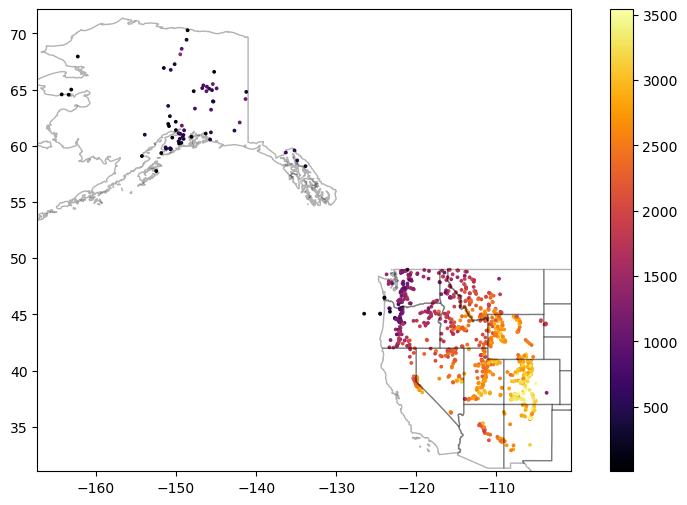

In [ ]:
f, ax = plt.subplots(figsize=(10,6))
sites_gdf_all.plot(ax=ax, column='elevation_m', markersize=3, cmap='inferno', legend=True)
ax.autoscale(False)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='k', alpha=0.3);

### Exclude the Alaska (AK) points to isolate points over Western U.S.
* Can remove points where the site name contains 'AK' or can use a spatial filter (see GeoPandas cx indexer functionality)
* Note the number of records

In [ ]:
sites_gdf_all = sites_gdf_all[~(sites_gdf_all.index.str.contains('AK'))]
#xmin, xmax, ymin, ymax = [-126, 102, 30, 50]
#sites_gdf_all = sites_gdf_all.cx[xmin:xmax, ymin:ymax]
sites_gdf_all.shape

(865, 19)

### Update scatterplot as sanity check
* Should look something like the Western U.S.

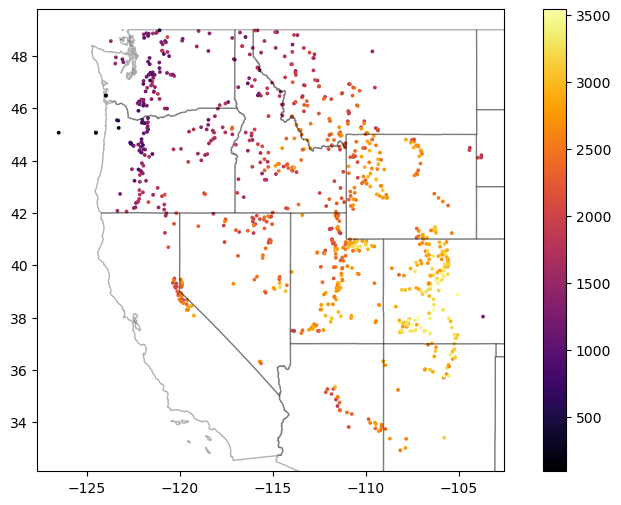

In [ ]:
f, ax = plt.subplots(figsize=(10,6))
sites_gdf_all.plot(ax=ax, column='elevation_m', markersize=3, cmap='inferno', legend=True)
ax.autoscale(False)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='k', alpha=0.3);

### Export SNOTEL site GeoDataFrame as a geojson
* Maybe useful for later lab or other analysis

In [ ]:
sites_fn = os.path.join(datadir, 'snotel_conus_sites.json')
if not os.path.exists(sites_fn):
    print('Writing out:', sites_fn)
    sites_gdf_all.to_file(sites_fn, driver='GeoJSON')

## Part 2: Time series analysis for one station
Now that we've identified sites of interest, let's query the API to obtain the time series data for variables of interest (snow!).

In [ ]:
#Interactive basemap - useful to select a site of interest
#sites_gdf_all.explore(column='elevation_m')

In [ ]:
#Hart's Pass
#sitecode = 'SNOTEL:515_WA_SNTL'
#Paradise
sitecode = 'SNOTEL:679_WA_SNTL'

### Query the server for information about this site
* Use the ulmo cuahsi `get_site_info` method here
* Lots of output here, try to skim and get a sense of the different parameters and associated metadata
* Note that there are many standard meteorological variables that can be downloaded for this site, in addition to the snow depth and snow water equivalent.
    * Careful about using some variables - documented bias in measurements
    * https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014GL062803

In [ ]:
site_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, sitecode)
#site_info

## Inspect the returned information
* Note number of available variables in the time series data!

In [ ]:
dict_keys = site_info['series'].keys()
dict_keys

dict_keys(['SNOTEL:BATT_D', 'SNOTEL:BATT_H', 'SNOTEL:PRCP_y', 'SNOTEL:PRCP_sm', 'SNOTEL:PRCP_m', 'SNOTEL:PRCP_wy', 'SNOTEL:PRCPSA_y', 'SNOTEL:PRCPSA_D', 'SNOTEL:PRCPSA_sm', 'SNOTEL:PRCPSA_m', 'SNOTEL:PRCPSA_wy', 'SNOTEL:PREC_sm', 'SNOTEL:PREC_m', 'SNOTEL:PREC_wy', 'SNOTEL:SNWD_D', 'SNOTEL:SNWD_sm', 'SNOTEL:SNWD_H', 'SNOTEL:SNWD_m', 'SNOTEL:TAVG_y', 'SNOTEL:TAVG_D', 'SNOTEL:TAVG_sm', 'SNOTEL:TAVG_m', 'SNOTEL:TAVG_wy', 'SNOTEL:TMAX_y', 'SNOTEL:TMAX_D', 'SNOTEL:TMAX_sm', 'SNOTEL:TMAX_m', 'SNOTEL:TMAX_wy', 'SNOTEL:TMIN_y', 'SNOTEL:TMIN_D', 'SNOTEL:TMIN_sm', 'SNOTEL:TMIN_m', 'SNOTEL:TMIN_wy', 'SNOTEL:TOBS_D', 'SNOTEL:TOBS_sm', 'SNOTEL:TOBS_H', 'SNOTEL:TOBS_m', 'SNOTEL:WTEQ_D', 'SNOTEL:WTEQ_sm', 'SNOTEL:WTEQ_H', 'SNOTEL:WTEQ_m'])

In [ ]:
len(dict_keys)

41

Note on units:
* _H = "hourly"
* _D = "daily"
* _sm, _m = "monthly"
* _y = "yearly"
* _wy = "water year"

## Let's consider the 'SNOTEL:SNWD_D' variable (Daily Snow Depth)
* Assign 'SNOTEL:SNWD_D' to a variable named `variablecode`
* Get some information about the variable using `get_variable_info` method
* Note the units, nodata value, etc.
* **Note: The snow depth records are almost always shorter/noisier than the SWE records for SNOTEL sites**

In [ ]:
#Daily SWE
#variablecode = 'SNOTEL:WTEQ_D'
#Daily snow depth
variablecode = 'SNOTEL:SNWD_D'

In [ ]:
#Hourly SWE
#variablecode = 'SNOTEL:WTEQ_H'
#Hourly snow depth
#variablecode = 'SNOTEL:SNWD_H'

In [ ]:
ulmo.cuahsi.wof.get_variable_info(wsdlurl, variablecode)

{'value_type': 'Field Observation',
 'data_type': 'Continuous',
 'general_category': 'Soil',
 'sample_medium': 'Snow',
 'no_data_value': '-9999',
 'speciation': 'Not Applicable',
 'code': 'SNWD_D',
 'id': '176',
 'name': 'Snow depth',
 'vocabulary': 'SNOTEL',
 'time': {'is_regular': True,
  'interval': '1',
  'units': {'abbreviation': 'd',
   'code': '104',
   'name': 'day',
   'type': 'Time'}},
 'units': {'abbreviation': 'in',
  'code': '49',
  'name': 'international inch',
  'type': 'Length'}}

## Define a function to fetch time series data
* Can define specific start and end dates, or get full record (default)
* I've done this for you, but please review the comments and steps to see what is going on under the hood
* You'll probably have to do similar data wrangling for another project at some point in the future

In [ ]:
today = pd.to_datetime("today")
today.strftime('%Y-%m-%d')

'2023-02-25'

In [ ]:
#Get current datetime
today = pd.to_datetime("today").strftime('%Y-%m-%d')

def snotel_fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date='1950-10-01', end_date=today):
    #print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
    except:
        print(f"Unable to fetch {variablecode} for {sitecode}")
    else:
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']

    return values_df

### Use this function to get the full 'SNOTEL:SNWD_D' record for one station
* Inspect the results
* We used a dummy start date of Jan 1, 1950.  What is the actual the first date returned?

In [ ]:
%%time
print(sitecode)
#values_df = snotel_fetch(sitecode, variablecode, start_date, end_date)
values_df = snotel_fetch(sitecode, variablecode)

SNOTEL:679_WA_SNTL
CPU times: user 686 ms, sys: 10.4 ms, total: 696 ms
Wall time: 3.21 s


In [ ]:
values_df.head()

,value,qualifiers,censor_code,date_time_utc,method_id,method_code,source_code,quality_control_level_code
datetime,,,,,,,,
2006-08-18 00:00:00+00:00,0.0,E,nc,2006-08-18T00:00:00,0,0,1,1
2006-08-19 00:00:00+00:00,0.0,E,nc,2006-08-19T00:00:00,0,0,1,1
2006-08-20 00:00:00+00:00,0.0,E,nc,2006-08-20T00:00:00,0,0,1,1
2006-08-21 00:00:00+00:00,0.0,E,nc,2006-08-21T00:00:00,0,0,1,1
2006-08-22 00:00:00+00:00,0.0,E,nc,2006-08-22T00:00:00,0,0,1,1


In [ ]:
values_df.tail()

,value,qualifiers,censor_code,date_time_utc,method_id,method_code,source_code,quality_control_level_code
datetime,,,,,,,,
2023-02-21 00:00:00+00:00,118.0,V,nc,2023-02-21T00:00:00,0,0,1,1
2023-02-22 00:00:00+00:00,123.0,V,nc,2023-02-22T00:00:00,0,0,1,1
2023-02-23 00:00:00+00:00,NaN,NaN,nc,2023-02-23T00:00:00,0,0,1,1
2023-02-24 00:00:00+00:00,124.0,V,nc,2023-02-24T00:00:00,0,0,1,1
2023-02-25 00:00:00+00:00,122.0,V,nc,2023-02-25T00:00:00,0,0,1,1


### Create a quick plot to view the time series
* Take a moment to inspect the `value` column, which is where the `SNWD_D` values are stored
* Sanity check thought question: *What are the units again?*

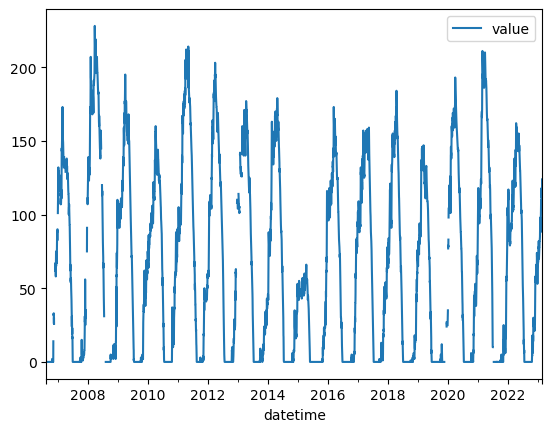

In [ ]:
values_df.plot();

### Write out the dataframe to disk
* Can use a number of different formats here, easiest to use a "pickle": https://www.pythoncentral.io/how-to-pickle-unpickle-tutorial/
* Define a unique filename for the dataset (e.g., `pkl_fn='snotel_wa_snwd_d.pkl'`)
* Write the DataFrame to disk

In [ ]:
pkl_fn = os.path.join(datadir, f"{variablecode.replace(':','-')}_{sitecode.split(':')[-1]}.pkl")
pkl_fn

'snotel_data/SNOTEL-SNWD_D_679_WA_SNTL.pkl'

In [ ]:
print(f"Writing out: {pkl_fn}")
values_df.to_pickle(pkl_fn)

Writing out: snotel_data/SNOTEL-SNWD_D_679_WA_SNTL.pkl


### Read it back in to check

In [ ]:
pd.read_pickle(pkl_fn)

,value,qualifiers,censor_code,date_time_utc,method_id,method_code,source_code,quality_control_level_code
datetime,,,,,,,,
2006-08-18 00:00:00+00:00,0.0,E,nc,2006-08-18T00:00:00,0,0,1,1
2006-08-19 00:00:00+00:00,0.0,E,nc,2006-08-19T00:00:00,0,0,1,1
2006-08-20 00:00:00+00:00,0.0,E,nc,2006-08-20T00:00:00,0,0,1,1
2006-08-21 00:00:00+00:00,0.0,E,nc,2006-08-21T00:00:00,0,0,1,1
2006-08-22 00:00:00+00:00,0.0,E,nc,2006-08-22T00:00:00,0,0,1,1
...,...,...,...,...,...,...,...,...
2023-02-21 00:00:00+00:00,118.0,V,nc,2023-02-21T00:00:00,0,0,1,1
2023-02-22 00:00:00+00:00,123.0,V,nc,2023-02-22T00:00:00,0,0,1,1
2023-02-23 00:00:00+00:00,NaN,NaN,nc,2023-02-23T00:00:00,0,0,1,1


## Part 3: Retrieve time series records for **All** SNOTEL Sites
* Now that we've explored one site, let's look at them all!
* Probably going to be some interesting spatial/temporal variability in these metrics

#### Notes:
* I've providing the following code to do this for you. Please review so you understand what's going on:
    * Loop through all sites names in the sites GeoDataFrame and run the above `snotel_fetch` function
    * Store output in a dictionary
    * Convert the dictionary to a Pandas Dataframe
    * Write final output to disk
* Note that this could take some time to run for all SNOTEL sites (~10-40 min, depending on server load)
    * Progress will be printed out incrementally
    * While you wait, explore some of the above links, or review remainder of lab
* Several sites may return an error (e.g., `<suds.sax.document.Document object at 0x7f0813040730>`)
    * Fortunately, this is handled by the `try-except` block in the `snotel_fetch` function above
    * This warning could arise for a number of reasons:
        * The site doesn't have an ultrasonic snow depth sensor: https://doi.org/10.1175/2007JTECHA947.1
        * The site was decomissioned or never produced valid data
        * The data are not available on the CUAHSI server
        * There was an issue connecting with the CUAHSI server
    * Most likely the first issue.  Some of these sites should have valid records for SWE, but not SD

In [ ]:
#Fetch desired SNOTEL data for all sites in the provided GeoDataFrame
def snotel_fetch_multisite(gdf, variablecode, pkl_fn):
    if os.path.exists(pkl_fn):
        snwd_df = pd.read_pickle(pkl_fn)
    else:
        #Define an empty dictionary to store returns for each site
        value_dict = {}
        #Loop through each site and add record to dictionary
        for i, sitecode in enumerate(gdf.index):
            print('%i of %i sites: %s' % (i+1, len(gdf.index), sitecode))
            #out = snotel_fetch(sitecode, variablecode, start_date, end_date)
            out = snotel_fetch(sitecode, variablecode)
            if out is not None:
                value_dict[sitecode] = out['value']

        #Convert the dictionary to a DataFrame, automatically handles different datetime ranges (nice!)
        snwd_df = pd.DataFrame.from_dict(value_dict)
        #Write out
        print(f"Writing out: {pkl_fn}")
        snwd_df.to_pickle(pkl_fn)
    return snwd_df

### Prepare SNWD_D for all CONUS sites

In [ ]:
%%time
variablecode = 'SNOTEL:SNWD_D'
pkl_fn = os.path.join(datadir, f"{variablecode.replace(':','-')}_CONUS_all.pkl")

snwd_df = snotel_fetch_multisite(sites_gdf_all, variablecode, pkl_fn)

CPU times: user 196 µs, sys: 96.4 ms, total: 96.6 ms
Wall time: 96.3 ms


### Prepare WTEQ_D for all WA sites
* We will use this for Week09 demo

In [ ]:
#Isolate WA sites
wa_idx = sites_gdf_all.index.str.contains('WA')
sites_gdf_wa = sites_gdf_all[wa_idx]
sites_gdf_wa.shape

(84, 19)

In [ ]:
%%time
variablecode = 'SNOTEL:WTEQ_D'
pkl_fn = os.path.join(datadir, f"{variablecode.replace(':','-')}_WA.pkl")

wteq_df = snotel_fetch_multisite(sites_gdf_wa, variablecode, pkl_fn)

CPU times: user 293 µs, sys: 13.4 ms, total: 13.7 ms
Wall time: 11.2 ms


## Inspect the DataFrame
* Note structure, number of timestamps, NaNs
* What is the date of the first snow depth measurement in the network?
    * Note that the water equivalent (WTEQ_D) measurements from snow pillows extend much farther back in time, back to the early 1980s, before the ultrasonic snow depth instruments were incorporated across the network.  These are better to use for long-term studies.

In [ ]:
snwd_df.shape

(14025, 806)

In [ ]:
snwd_df.head()

,SNOTEL:301_CA_SNTL,SNOTEL:907_UT_SNTL,SNOTEL:916_MT_SNTL,SNOTEL:908_WA_SNTL,SNOTEL:302_OR_SNTL,SNOTEL:1000_OR_SNTL,SNOTEL:303_CO_SNTL,SNOTEL:1030_CO_SNTL,SNOTEL:304_OR_SNTL,SNOTEL:306_ID_SNTL,...,SNOTEL:872_WY_SNTL,SNOTEL:873_OR_SNTL,SNOTEL:874_CO_SNTL,SNOTEL:875_WY_SNTL,SNOTEL:876_MT_SNTL,SNOTEL:877_AZ_SNTL,SNOTEL:1228_UT_SNTL,SNOTEL:1197_UT_SNTL,SNOTEL:878_WY_SNTL,SNOTEL:1033_CO_SNTL
datetime,,,,,,,,,,,,,,,,,,,,,
1984-10-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-10-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-10-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-10-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-10-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
snwd_df.tail()

,SNOTEL:301_CA_SNTL,SNOTEL:907_UT_SNTL,SNOTEL:916_MT_SNTL,SNOTEL:908_WA_SNTL,SNOTEL:302_OR_SNTL,SNOTEL:1000_OR_SNTL,SNOTEL:303_CO_SNTL,SNOTEL:1030_CO_SNTL,SNOTEL:304_OR_SNTL,SNOTEL:306_ID_SNTL,...,SNOTEL:872_WY_SNTL,SNOTEL:873_OR_SNTL,SNOTEL:874_CO_SNTL,SNOTEL:875_WY_SNTL,SNOTEL:876_MT_SNTL,SNOTEL:877_AZ_SNTL,SNOTEL:1228_UT_SNTL,SNOTEL:1197_UT_SNTL,SNOTEL:878_WY_SNTL,SNOTEL:1033_CO_SNTL
datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-19 00:00:00+00:00,42.0,33.0,48.0,78.0,55.0,76.0,8.0,60.0,44.0,68.0,...,27.0,48.0,88.0,29.0,25.0,26.0,39.0,37.0,35.0,63.0
2023-02-20 00:00:00+00:00,41.0,32.0,47.0,84.0,56.0,75.0,8.0,62.0,44.0,70.0,...,28.0,49.0,88.0,33.0,26.0,24.0,39.0,36.0,37.0,68.0
2023-02-21 00:00:00+00:00,40.0,31.0,46.0,86.0,55.0,73.0,10.0,61.0,43.0,71.0,...,29.0,48.0,86.0,42.0,33.0,21.0,39.0,35.0,42.0,68.0
2023-02-22 00:00:00+00:00,40.0,32.0,53.0,NaN,56.0,83.0,6.0,NaN,51.0,76.0,...,39.0,52.0,86.0,45.0,35.0,19.0,44.0,34.0,46.0,70.0
2023-02-23 00:00:00+00:00,44.0,38.0,52.0,91.0,56.0,90.0,8.0,67.0,52.0,78.0,...,NaN,57.0,98.0,44.0,33.0,23.0,45.0,41.0,45.0,73.0


In [ ]:
snwd_df.describe()

,SNOTEL:301_CA_SNTL,SNOTEL:907_UT_SNTL,SNOTEL:916_MT_SNTL,SNOTEL:908_WA_SNTL,SNOTEL:302_OR_SNTL,SNOTEL:1000_OR_SNTL,SNOTEL:303_CO_SNTL,SNOTEL:1030_CO_SNTL,SNOTEL:304_OR_SNTL,SNOTEL:306_ID_SNTL,...,SNOTEL:872_WY_SNTL,SNOTEL:873_OR_SNTL,SNOTEL:874_CO_SNTL,SNOTEL:875_WY_SNTL,SNOTEL:876_MT_SNTL,SNOTEL:877_AZ_SNTL,SNOTEL:1228_UT_SNTL,SNOTEL:1197_UT_SNTL,SNOTEL:878_WY_SNTL,SNOTEL:1033_CO_SNTL
count,8971.000000,8909.000000,9660.000000,6833.000000,7954.000000,8193.000000,8365.000000,7139.000000,7197.000000,9711.000000,...,6349.000000,6461.000000,9104.000000,7864.000000,7533.000000,6920.000000,3863.000000,3879.000000,8272.000000,7284.000000
mean,9.815851,7.407790,24.913458,36.359579,27.014332,35.334798,5.964136,29.431013,15.439489,32.198126,...,9.114506,15.036372,34.276911,11.033698,10.453339,3.697688,10.476831,8.383346,18.256770,26.014690
std,14.651453,12.660844,23.422584,42.755263,26.955982,40.036953,9.399264,27.698495,19.887877,35.128416,...,11.477779,19.419041,36.237121,14.216598,12.869854,7.669382,14.125755,11.750906,20.047268,29.159213
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,22.000000,17.000000,21.000000,20.000000,0.000000,24.000000,0.000000,19.000000,...,3.000000,0.000000,25.000000,1.000000,4.000000,0.000000,0.000000,0.000000,10.000000,13.000000
75%,18.000000,12.000000,44.000000,69.000000,48.000000,67.000000,9.000000,55.000000,32.000000,60.000000,...,17.000000,31.000000,63.000000,22.000000,20.000000,3.000000,22.000000,17.000000,34.000000,51.000000
max,66.000000,70.000000,95.000000,175.000000,107.000000,162.000000,53.000000,106.000000,76.000000,144.000000,...,139.000000,75.000000,198.000000,64.000000,61.000000,56.000000,60.000000,55.000000,79.000000,111.000000
